In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
mu_per_sim = [20, 40, 60, 80, 100, 140, 200, 300]
n_diff_mus = len(mu_per_sim)
n_msmnts = 10
n_events_per_mu = 9
n_total_events = n_events_per_mu * n_diff_mus
n_diff_threads = 16

thread_nos = np.arange(1, n_diff_threads + 1, dtype=np.int32) * 64

hk_fconn_mu_setup_times = np.zeros((n_diff_threads, n_msmnts, n_total_events))
hk_fconn_mu_times = np.zeros((n_diff_threads, n_msmnts, n_total_events))
mu_SPCCL_CPU_times = np.zeros((n_diff_threads, n_msmnts, n_total_events))
mu_SPCCL_GPU_times = np.zeros((n_msmnts, n_total_events))
mu_SPCCL_CPU_times2 = np.zeros((n_msmnts, n_total_events))

hk_fconn_mu_track_accuracy = np.zeros((n_diff_threads, n_msmnts, n_total_events))
hk_fconn_mu_msmnt_accuracy = np.zeros((n_diff_threads, n_msmnts, n_total_events))
spccl_gpu_track_accuracy = np.zeros((n_msmnts, n_total_events))
spccl_gpu_msmnt_accuracy = np.zeros((n_msmnts, n_total_events))

n_modules_per_event = np.zeros(n_total_events, dtype=np.int32)
n_cells_per_event = np.zeros(n_total_events, dtype=np.int32)

In [134]:
# set the number of modules and cells
for l, mu in enumerate(mu_per_sim):
    # use just 64 threads and first run to get this, will be the same for all thread numbers
    path = "fconn_mu" + str(mu) +"/64/1.txt"
    with open(path) as file:
        lines = file.readlines()

    event_start_line = 1 + 14*(10 - n_events_per_mu)
    for k in range(n_events_per_mu):
        
        #print(lines)
        total_event_idx = l*n_events_per_mu + k
        #print(f"Path: {path}. t={total_event_idx}. event_start_line={event_start_line}")
        n_modules_per_event[total_event_idx] = int(lines[1 + event_start_line][19:-1])
        n_cells_per_event[total_event_idx] = int(lines[2 + event_start_line][34:-1])
        
        event_start_line += 14  # go to the next event
        

In [124]:
# SPCCL on GPU
for l, mu in enumerate(mu_per_sim):
    for i in range(n_msmnts):
        path = "spccl_gpu/mu" + str(mu) + "/" + str(i+1) + ".txt"
        #print(path)
        with open(path) as file:
            lines = file.readlines()

        event_start_line = 1 + 14*(10 - n_events_per_mu)
        for k in range(n_events_per_mu):
            t = l*n_events_per_mu + k  # t = total_event_idx
            #print(path)
            mu_SPCCL_GPU_times[i, t] = float(lines[event_start_line + 5][35:-2])
            mu_SPCCL_CPU_times2[i, t] = float(lines[event_start_line + 6][39:-2])
            spccl_gpu_track_accuracy[i, t] = float(lines[event_start_line + 10][29:-1])
            spccl_gpu_msmnt_accuracy[i, t] = float(lines[event_start_line + 13][33:-1])

            event_start_line += 14  # go to the next event

In [125]:
# FCONN
for l, mu in enumerate(mu_per_sim):
    for i in range(n_msmnts):
        for j, thread_no in enumerate(thread_nos):
            path = "fconn_mu" + str(mu) + "/" + str(thread_no) + "/" + str(i+1) + ".txt"
            #print(path)
            with open(path) as file:
                lines = file.readlines()

            event_start_line = 1 + 14*(10 - n_events_per_mu)
            for k in range(n_events_per_mu):
                t = l*n_events_per_mu + k  # t = total_event_idx
                #print(path)
                hk_fconn_mu_setup_times[j, i, t] = float(lines[event_start_line + 4][25:-2])
                hk_fconn_mu_times[j, i, t] = float(lines[event_start_line + 5][34:-2])
                mu_SPCCL_CPU_times[j, i, t] = float(lines[event_start_line + 6][39:-2])
                hk_fconn_mu_msmnt_accuracy[j, i, t] = float(lines[event_start_line + 10][29:-1])
                hk_fconn_mu_track_accuracy[j, i, t] = float(lines[event_start_line + 13][33:-1])

                event_start_line += 14  # go to the next event

In [135]:
n_cells_per_event

array([ 40690,  24949,  40855,  35143,  38976,  60506,  24765,  48702,
        32329,  70596,  62383,  53969,  67050,  68033, 100916,  44408,
        75431,  61056, 102243, 116426,  84124,  90410,  98787, 138479,
        77856, 102375, 100471, 141963, 132186, 118481, 126438, 148851,
       176448, 112641, 137360, 136883, 183463, 155586, 151650, 174957,
       167304, 212745, 162070, 166654, 159667, 268281, 221248, 205805,
       225105, 233925, 251321, 231681, 233813, 190825, 368764, 314769,
       308440, 344515, 334829, 348601, 310047, 330791, 257011, 542047,
       479904, 432026, 514677, 461332, 500188, 502140, 473937, 423891],
      dtype=int32)

In [136]:
n_modules_per_event

array([ 5532,  4122,  5543,  4966,  5603,  7065,  4021,  6103,  4890,
        7287,  7345,  6533,  7418,  7603,  8990,  5630,  7834,  6993,
        8759,  9685,  8217,  8475,  9089, 10168,  7778,  8964,  8878,
       10133, 10144,  9573,  9672, 10790, 11215,  9144, 10169, 10066,
       11114, 10732, 10673, 11151, 11238, 11950, 10517, 10858, 10706,
       12618, 11949, 11739, 12099, 12415, 12317, 12154, 12215, 11366,
       13900, 13263, 13264, 13744, 13791, 13597, 13151, 13464, 12462,
       15165, 14634, 14441, 15041, 14877, 14781, 14800, 14565, 14295],
      dtype=int32)

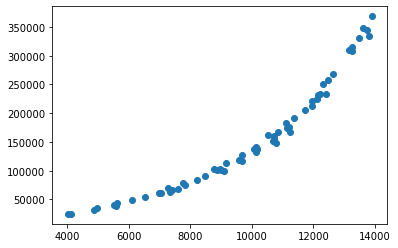

In [22]:
plt.plot(n_modules_per_event, n_cells_per_event, "o")
#plt.yscale("log")
plt.show()

In [111]:
hk_fconn_mu_times.shape

(16, 10, 72)

In [145]:
n_total_msmnts_wrt_thread = n_total_events * n_msmnts
n_total_msmnts_wrt_event = n_diff_threads * n_msmnts

# get time wrt the number of threads
hk_fconn_mu_means_wrt_thread = np.mean(hk_fconn_mu_times.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1)
hk_fconn_mu_std_wrt_thread = np.std(hk_fconn_mu_times.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1)
hk_fconn_mu_err_wrt_thread = hk_fconn_mu_std_wrt_thread / np.sqrt(n_total_msmnts_wrt_thread)

mu_SPCCL_CPU_means_wrt_thread = np.mean(mu_SPCCL_CPU_times.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1)
mu_SPCCL_CPU_std_wrt_thread = np.std(mu_SPCCL_CPU_times.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1)
mu_SPCCL_CPU_err_wrt_thread = mu_SPCCL_CPU_std_wrt_thread / np.sqrt(n_total_msmnts_wrt_thread)

# get the time wrt the module and cell number
hk_fconn_mu_means_wrt_event = np.mean(hk_fconn_mu_times.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0)
hk_fconn_mu_std_wrt_event = np.std(hk_fconn_mu_times.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0)
hk_fconn_mu_err_wrt_event = hk_fconn_mu_std_wrt_event / np.sqrt(n_total_msmnts_wrt_event)

hk_fconn_mu_means_1024_threads = np.mean(hk_fconn_mu_times[15,:,:].reshape(n_msmnts, n_total_events), axis=0)
hk_fconn_mu_std_1024_threads = (np.std(hk_fconn_mu_times[15,:,:].reshape(n_msmnts, n_total_events), axis=0))
hk_fconn_mu_err_1024_threads = hk_fconn_mu_std_1024_threads / np.sqrt(n_msmnts)

mu_SPCCL_CPU_means_wrt_event = np.mean(mu_SPCCL_CPU_times.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0)
mu_SPCCL_CPU_std_wrt_event = np.std(mu_SPCCL_CPU_times.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0)
mu_SPCCL_CPU_err_wrt_event = mu_SPCCL_CPU_std_wrt_event / np.sqrt(n_total_msmnts_wrt_event)

# get the time wrt the module and cell number for SPCCL on GPU
mu_SPCCL_CPU_means2 = np.mean(mu_SPCCL_CPU_times2, axis=0)
mu_SPCCL_CPU_std2 = np.std(mu_SPCCL_CPU_times2, axis=0)
mu_SPCCL_CPU_err2 = mu_SPCCL_CPU_std2 / np.sqrt(n_msmnts)

mu_SPCCL_GPU_means = np.mean(mu_SPCCL_GPU_times, axis=0)
mu_SPCCL_GPU_std = np.std(mu_SPCCL_GPU_times, axis=0)
mu_SPCCL_GPU_err = mu_SPCCL_GPU_std / np.sqrt(n_msmnts)

In [146]:
print(hk_fconn_mu_means_wrt_event)

[0.00095273 0.00055232 0.00095886 0.00081544 0.00090497 0.00147359
 0.00055229 0.00115881 0.00073936 0.00171151 0.00149278 0.00127384
 0.00160029 0.00162348 0.00258695 0.00104332 0.00187476 0.00143376
 0.00264824 0.00308184 0.00209849 0.00226433 0.00249927 0.00374249
 0.00189525 0.00269896 0.00262881 0.00386003 0.00352751 0.00309142
 0.00335369 0.00406315 0.00494428 0.00291588 0.00377066 0.00368191
 0.00534349 0.00426801 0.00414875 0.00492619 0.00468826 0.00632268
 0.00460137 0.00475459 0.00444109 0.00820878 0.00648409 0.00597769
 0.00665762 0.00692589 0.00770164 0.00692156 0.00706364 0.00543222
 0.01178717 0.00977777 0.00960552 0.01088472 0.0105777  0.01118586
 0.00960818 0.01048726 0.00772567 0.01886324 0.01610697 0.01431308
 0.01753419 0.0155271  0.01718965 0.01716851 0.01598392 0.01397897]


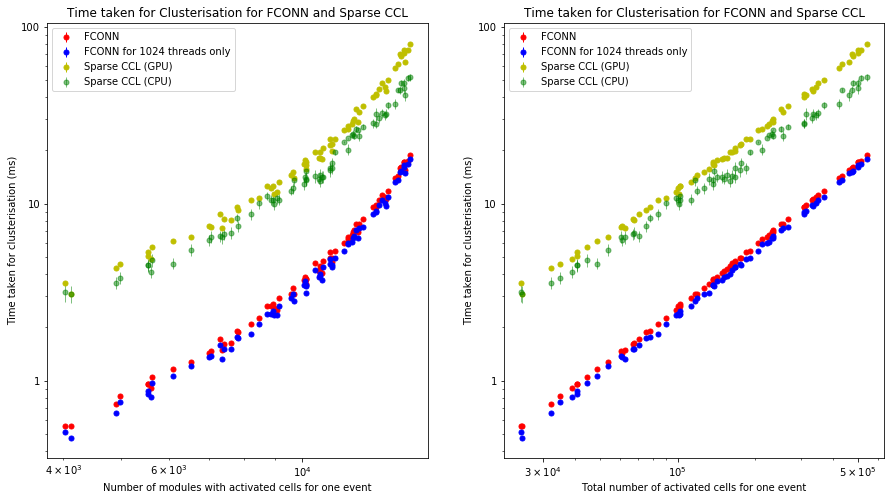

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.errorbar(n_modules_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN", color="r")
ax1.errorbar(n_modules_per_event, hk_fconn_mu_means_1024_threads, yerr=hk_fconn_mu_err_1024_threads,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN for 1024 threads only", color="b")
# ax1.errorbar(n_modules_per_event, mu_SPCCL_CPU_means_wrt_event, yerr=mu_SPCCL_CPU_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL with HK (CPU)", color="y", alpha=0.5)
ax1.errorbar(n_modules_per_event, mu_SPCCL_GPU_means, yerr=mu_SPCCL_GPU_err,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU)", color="y")
ax1.errorbar(n_modules_per_event, mu_SPCCL_CPU_means2, yerr=mu_SPCCL_CPU_err2,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (CPU)", color="g", alpha=0.5)
ax1.set_xlabel("Number of modules with activated cells for one event")
ax1.set_ylabel("Time taken for clusterisation (ms)")
ax1.set_title("Time taken for Clusterisation for FCONN and Sparse CCL")
ax1.legend()

ax2.errorbar(n_cells_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN", color="r")
ax2.errorbar(n_cells_per_event, hk_fconn_mu_means_1024_threads, yerr=hk_fconn_mu_err_1024_threads,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN for 1024 threads only", color="b")
# ax2.errorbar(n_cells_per_event, mu_SPCCL_CPU_means_wrt_event, yerr=mu_SPCCL_CPU_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL with HK (CPU)", color="y", alpha=0.5)
ax2.errorbar(n_cells_per_event, mu_SPCCL_GPU_means, yerr=mu_SPCCL_GPU_err,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU)", color="y")
ax2.errorbar(n_cells_per_event, mu_SPCCL_CPU_means2, yerr=mu_SPCCL_CPU_err2,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (CPU)", color="g", alpha=0.5)
ax2.set_xlabel("Total number of activated cells for one event")
ax2.set_ylabel("Time taken for clusterisation (ms)")
ax2.set_title("Time taken for Clusterisation for FCONN and Sparse CCL")
ax2.legend()

# ax2.errorbar(n_modules_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="FCONN")
# ax2.errorbar(n_modules_per_event, mu_SPCCL_CPU_means_wrt_event, yerr=mu_SPCCL_CPU_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL")
# ax2.legend()
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yticklabels((ax1.get_yticks() * 1000).astype(np.int32))

ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yticklabels((ax2.get_yticks() * 1000).astype(np.int32))
ax2.set_xticks([3e4, 1e5, 5e5])
ax2.set_xticklabels([r"$3 \times 10^4$", r"$10^5$", r"$5 \times 10^5$"])

plt.savefig("clusterisation_times_mu.pdf")

plt.show()

In [148]:
fconn_times_ratio = hk_fconn_mu_means_wrt_event/mu_SPCCL_CPU_means2
fconn_times_ratio_err = fconn_times_ratio * (hk_fconn_mu_err_wrt_event / hk_fconn_mu_means_wrt_event
                                            +mu_SPCCL_CPU_err2 / mu_SPCCL_CPU_means2)
fconn_times_ratio1024 = hk_fconn_mu_means_1024_threads/mu_SPCCL_CPU_means2
fconn_times_ratio1024_err = fconn_times_ratio * (hk_fconn_mu_err_1024_threads / hk_fconn_mu_means_1024_threads
                                                +mu_SPCCL_CPU_err2 / mu_SPCCL_CPU_means2)

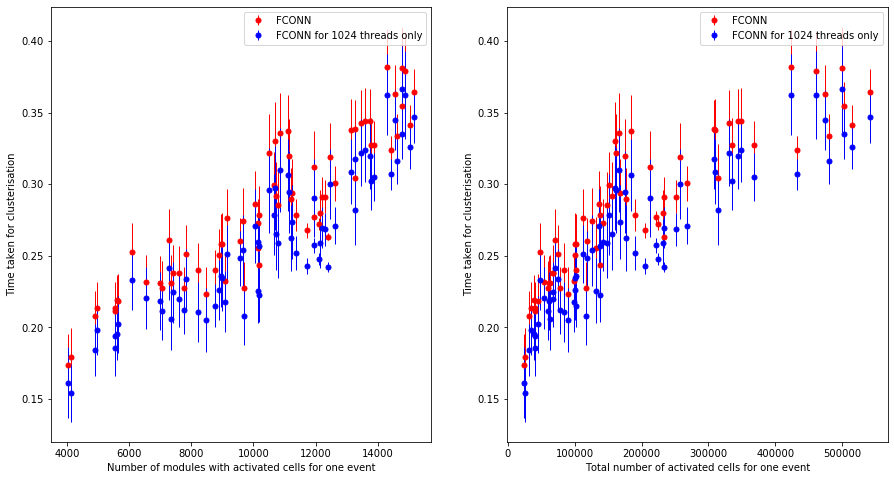

In [168]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.errorbar(n_modules_per_event, fconn_times_ratio, yerr=fconn_times_ratio_err,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN", color="r")
ax1.errorbar(n_modules_per_event, fconn_times_ratio1024, yerr=fconn_times_ratio1024_err,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN for 1024 threads only", color="b")
ax1.set_xlabel("Number of modules with activated cells for one event")
ax1.set_ylabel("Time taken for clusterisation")
ax1.legend()

ax2.errorbar(n_cells_per_event, fconn_times_ratio, yerr=fconn_times_ratio_err,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN", color="r")
ax2.errorbar(n_cells_per_event, fconn_times_ratio1024, yerr=fconn_times_ratio1024_err,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN for 1024 threads only", color="b")

ax2.set_xlabel("Total number of activated cells for one event")
ax2.set_ylabel("Time taken for clusterisation")
ax2.legend()

# ax2.errorbar(n_modules_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="FCONN")
# ax2.errorbar(n_modules_per_event, mu_SPCCL_CPU_means_wrt_event, yerr=mu_SPCCL_CPU_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL")
# ax2.legend()
# ax1.set_yscale("log")
# ax1.set_xscale("log")

#ax2.set_yscale("log")
#ax2.set_xscale("log")
plt.savefig("clusterisation_times_mu_ratio.pdf")

plt.show()

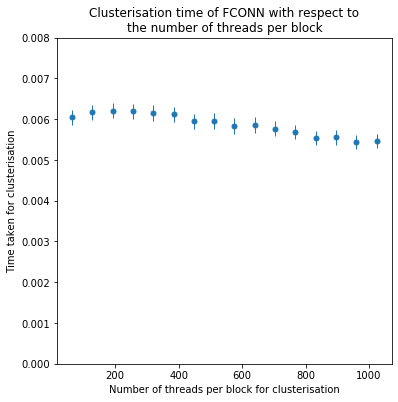

In [272]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))

ax1.errorbar(thread_nos, hk_fconn_mu_means_wrt_thread, yerr=hk_fconn_mu_err_wrt_thread,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN")
# ax1.errorbar(thread_nos, mu_SPCCL_CPU_means_wrt_thread, yerr=mu_SPCCL_CPU_err_wrt_thread,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL")
ax1.set_xlabel("Number of threads per block for clusterisation")
ax1.set_ylabel("Time taken for clusterisation")
ax1.set_title("Clusterisation time of FCONN with respect to\nthe number of threads per block")
#ax1.legend()
ax1.set_ylim(0,0.008)

plt.savefig("clusterisation_times_mu_wrt_threads.pdf")
plt.show()

In [152]:
# first get the mean spacepoint accuracy
# wrt the number of threads
hk_fconn_mu_track_acc_means_wrt_thread = (
    np.mean(hk_fconn_mu_track_accuracy.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1))
hk_fconn_mu_track_acc_std_wrt_thread = (
    np.std(hk_fconn_mu_track_accuracy.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1))
hk_fconn_mu_track_acc_err_wrt_thread = (
    hk_fconn_mu_track_acc_std_wrt_thread / np.sqrt(n_total_msmnts_wrt_thread))
# then wrt the number of modules/cells in the event
hk_fconn_mu_track_acc_means_wrt_event = (
    np.mean(hk_fconn_mu_track_accuracy.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0))
hk_fconn_mu_track_acc_std_wrt_event = (
    np.std(hk_fconn_mu_track_accuracy.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0))
hk_fconn_mu_track_acc_err_wrt_event = (
    hk_fconn_mu_track_acc_std_wrt_event / np.sqrt(n_total_msmnts_wrt_event))
# only for 1024
hk_fconn_mu_track_acc_means_1024_threads = (
    np.mean(hk_fconn_mu_track_accuracy[15,:,:].reshape(n_msmnts, n_total_events), axis=0))
hk_fconn_mu_track_acc_std_1024_threads = (
    np.std(hk_fconn_mu_track_accuracy[15,:,:].reshape(n_msmnts, n_total_events), axis=0))
hk_fconn_mu_track_acc_err_1024_threads = (
    hk_fconn_mu_track_acc_std_1024_threads / np.sqrt(n_total_msmnts_wrt_event))


# Now the same but for measurement accuracy
hk_fconn_mu_msmnt_acc_means_wrt_thread = (
    np.mean(hk_fconn_mu_msmnt_accuracy.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1))
hk_fconn_mu_msmnt_acc_std_wrt_thread = (
    np.std(hk_fconn_mu_msmnt_accuracy.reshape(n_diff_threads, n_total_msmnts_wrt_thread), axis=1))
hk_fconn_mu_msmnt_acc_err_wrt_thread = (
    hk_fconn_mu_msmnt_acc_std_wrt_thread / np.sqrt(n_total_msmnts_wrt_thread))
# then wrt the number of modules/cells in the event
hk_fconn_mu_msmnt_acc_means_wrt_event = (
    np.mean(hk_fconn_mu_msmnt_accuracy.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0))
hk_fconn_mu_msmnt_acc_std_wrt_event = (
    np.std(hk_fconn_mu_msmnt_accuracy.reshape(n_total_msmnts_wrt_event, n_total_events), axis=0))
hk_fconn_mu_msmnt_acc_err_wrt_event = (
    hk_fconn_mu_msmnt_acc_std_wrt_event / np.sqrt(n_total_msmnts_wrt_event))
# now wrt number of modules/cells in the event for just 1024 threads
hk_fconn_mu_msmnt_acc_means_1024_threads = (
    np.mean(hk_fconn_mu_msmnt_accuracy[15,:,:].reshape(n_msmnts, n_total_events), axis=0))
hk_fconn_mu_msmnt_acc_std_1024_threads = (
    np.std(hk_fconn_mu_msmnt_accuracy[15,:,:].reshape(n_msmnts, n_total_events), axis=0))
hk_fconn_mu_msmnt_acc_err_1024_threads = (
    hk_fconn_mu_msmnt_acc_std_1024_threads / np.sqrt(n_total_msmnts_wrt_event))

# SPCCL on GPU
spccl_gpu_msmnt_acc_means = np.mean(spccl_gpu_msmnt_accuracy, axis=0)
spccl_gpu_msmnt_acc_err = np.std(spccl_gpu_msmnt_accuracy, axis=0) / np.sqrt(n_msmnts)

spccl_gpu_track_acc_means = np.mean(spccl_gpu_track_accuracy, axis=0)
spccl_gpu_track_acc_err = np.std(spccl_gpu_track_accuracy, axis=0) / np.sqrt(n_msmnts)

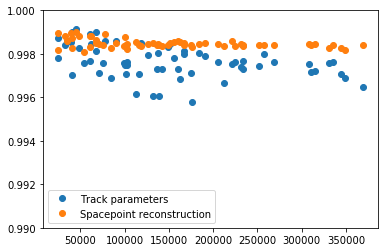

In [30]:
plt.plot(n_cells_per_event, hk_fconn_mu_track_acc_means_wrt_event, "o", label="Track parameters")
plt.plot(n_cells_per_event, hk_fconn_mu_msmnt_acc_means_wrt_event, "o", label="Spacepoint reconstruction")
plt.ylim(0.99,1)
plt.legend()
plt.show()

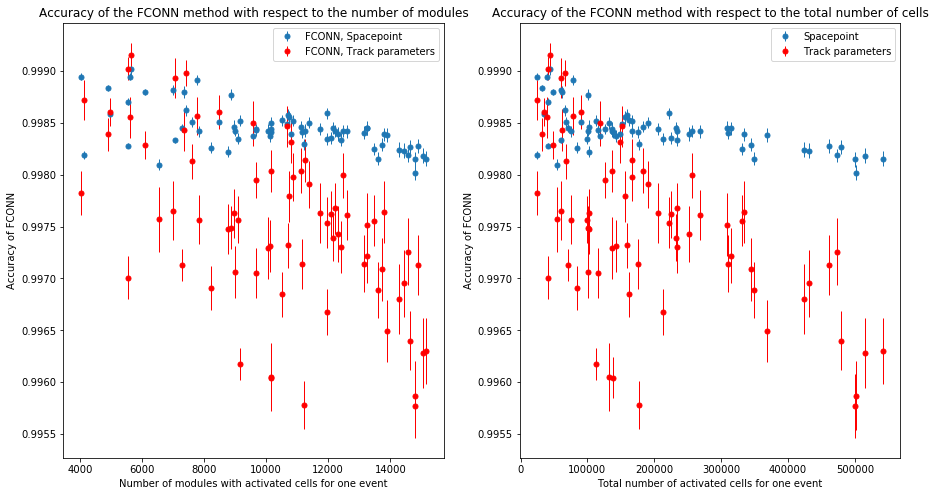

In [265]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.errorbar(n_modules_per_event, hk_fconn_mu_msmnt_acc_means_wrt_event, yerr=hk_fconn_mu_msmnt_acc_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN, Spacepoint")
# ax1.errorbar(n_modules_per_event, hk_fconn_mu_msmnt_acc_means_1024_threads,
#              yerr=hk_fconn_mu_msmnt_acc_err_1024_threads, ls="none", marker="o", markersize=5, lw=1,
#              label="Spacepoint accuracy for 1024 threads only", color="g")
ax1.errorbar(n_modules_per_event, hk_fconn_mu_track_acc_means_wrt_event, yerr=hk_fconn_mu_track_acc_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN, Track parameters", color="r")
# ax1.errorbar(n_modules_per_event, hk_fconn_mu_track_acc_means_1024_threads,
#              yerr=hk_fconn_mu_track_acc_err_1024_threads, ls="none", marker="o", markersize=5, lw=1,
#              label="Track parameter accuracy for 1024 threads only", color="purple")
# ax1.errorbar(n_modules_per_event, spccl_gpu_msmnt_acc_means, yerr=spccl_gpu_msmnt_acc_err,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU), Spacepoint", color="g")
# ax1.errorbar(n_modules_per_event, spccl_gpu_track_acc_means, yerr=spccl_gpu_track_acc_err,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU), Track parameters", color="purple")


ax1.set_xlabel("Number of modules with activated cells for one event")
ax1.set_ylabel("Accuracy of FCONN")
ax1.set_title("Accuracy of the FCONN method with respect to the number of modules")
ax1.legend()

ax2.errorbar(n_cells_per_event, hk_fconn_mu_msmnt_acc_means_wrt_event, yerr=hk_fconn_mu_msmnt_acc_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="Spacepoint")
# ax2.errorbar(n_cells_per_event, hk_fconn_mu_msmnt_acc_means_1024_threads,
#              yerr=hk_fconn_mu_msmnt_acc_err_1024_threads, ls="none", marker="o", markersize=5, lw=1,
#              label="Spacepoint accuracy for 1024 threads only", color="g")
ax2.errorbar(n_cells_per_event, hk_fconn_mu_track_acc_means_wrt_event, yerr=hk_fconn_mu_track_acc_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="Track parameters", color="r")
# ax2.errorbar(n_cells_per_event, hk_fconn_mu_track_acc_means_1024_threads,
#              yerr=hk_fconn_mu_track_acc_err_1024_threads, ls="none", marker="o", markersize=5, lw=1,
#              label="Track parameter accuracy for 1024 threads only", color="purple")
# ax2.errorbar(n_cells_per_event, spccl_gpu_msmnt_acc_means, yerr=spccl_gpu_msmnt_acc_err,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU), Spacepoint", color="g")
# ax2.errorbar(n_cells_per_event, spccl_gpu_track_acc_means, yerr=spccl_gpu_track_acc_err,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU), Track parameters", color="purple")
ax2.set_xlabel("Total number of activated cells for one event")
ax2.set_ylabel("Accuracy of FCONN")
ax2.set_title("Accuracy of the FCONN method with respect to the total number of cells")
ax2.legend()

# ax2.errorbar(n_modules_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="FCONN")
# ax2.errorbar(n_modules_per_event, mu_SPCCL_CPU_means_wrt_event, yerr=mu_SPCCL_CPU_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL")
# ax2.legend()
# ax1.set_yscale("log")
# ax1.set_xscale("log")

# ax2.set_yscale("log")
# ax2.set_xscale("log")

plt.savefig("accuracy_plots_mu.pdf")
plt.show()

In [237]:
from scipy.optimize import curve_fit

def ref_model_square(n, b, c, d, e):
    return (n**2)*(np.log(n)*b + c) + (n)*d + e

def ref_model_cube(n, a, b, c, d, e):
    return (n**3)*(np.log(n)*a + b) + (n**2)*c + (n)*d + e

def ref_model_coeffs_to_str(coeffs):
    n_coeffs = len(coeffs)
    final_str = ""
    for i, coeff in enumerate(coeffs):
        if (coeff < 0):
            final_str += " - "
        elif (coeff > 0):
            if (i != 0):  # only add + if it's not the first value
                final_str += " + "
        else:
            continue  # go to the next coeff if one is exactly zero
        coeff = np.abs(coeff)  # have already printed sign
        order = n_coeffs - 1 - i

        if (i == 0):  # this is the coeff for ln(n) * n^N
            if (coeff < 0.01):
                final_str += f"{coeff:.2E}ln(n)n^" + str(order-1)
            else:
                final_str += f"{coeff:.2f}ln(n)n^" + str(order-1)
            continue


        if (order == 0):
            if (coeff < 0.01):
                final_str += f"{coeff:.2E}"
            else:
                final_str += f"{coeff:.2f}"
        elif (order == 1):
            if (coeff < 0.01):
                final_str += f"{coeff:.2E}" + "n"
            else:
                final_str += f"{coeff:.2f}" + "n"
        else:
            if (coeff < 0.01):
                final_str += f"{coeff:.2E}" + "n^" + str(order)
            else:
                final_str += f"{coeff:.2f}" + "n^" + str(order)    
            
    
    return final_str

In [238]:
mod_fit_fconn_2 = curve_fit(ref_model_square, n_modules_per_event, hk_fconn_mu_means_wrt_event,
                            sigma=hk_fconn_mu_err_wrt_event)
mod_fit_fconn1024_2 = curve_fit(ref_model_square, n_modules_per_event, hk_fconn_mu_means_1024_threads,
                            sigma=hk_fconn_mu_err_1024_threads)
mod_fit_ccl_cpu_2 = curve_fit(ref_model_square, n_modules_per_event, mu_SPCCL_CPU_means2,
                              sigma=mu_SPCCL_CPU_err2)
mod_fit_ccl_gpu_2 = curve_fit(ref_model_square, n_modules_per_event, mu_SPCCL_GPU_means,
                              sigma=mu_SPCCL_GPU_err)

mod_fit_fconn_3 = curve_fit(ref_model_cube, n_modules_per_event, hk_fconn_mu_means_wrt_event,
                            sigma=hk_fconn_mu_err_wrt_event)
mod_fit_fconn1024_3 = curve_fit(ref_model_cube, n_modules_per_event, hk_fconn_mu_means_1024_threads,
                            sigma=hk_fconn_mu_err_1024_threads)
mod_fit_ccl_cpu_3 = curve_fit(ref_model_cube, n_modules_per_event, mu_SPCCL_CPU_means2,
                              sigma=mu_SPCCL_CPU_err2)
mod_fit_ccl_gpu_3 = curve_fit(ref_model_cube, n_modules_per_event, mu_SPCCL_GPU_means,
                              sigma=mu_SPCCL_GPU_err)

In [239]:
print(ref_model_coeffs_to_str(mod_fit_fconn_2[0]))
print(ref_model_coeffs_to_str(mod_fit_fconn_3[0]))

3.92E-10ln(n)n^2 - 3.98E-09n^2 + 4.81E-06n - 7.00E-03
5.07E-14ln(n)n^3 - 5.35E-13n^3 + 9.64E-10n^2 - 2.89E-06n + 4.00E-03


In [240]:
module_numbers = np.arange(4000, 16000, 10)

fconn_fit2 = ref_model_square(module_numbers, *mod_fit_fconn_2[0])
fconn1024_fit2 = ref_model_square(module_numbers, *mod_fit_fconn1024_2[0])
spccl_fit2 = ref_model_square(module_numbers, *mod_fit_ccl_cpu_2[0])
spccl_gpu_fit2 = ref_model_square(module_numbers, *mod_fit_ccl_gpu_2[0])

fconn_fit3 = ref_model_cube(module_numbers, *mod_fit_fconn_3[0])
fconn1024_fit3 = ref_model_cube(module_numbers, *mod_fit_fconn1024_3[0])
spccl_fit3 = ref_model_cube(module_numbers, *mod_fit_ccl_cpu_3[0])
spccl_gpu_fit3 = ref_model_cube(module_numbers, *mod_fit_ccl_gpu_3[0])

In [241]:
fconn2_fit_str = ref_model_coeffs_to_str(mod_fit_fconn_2[0])
fconn3_fit_str = ref_model_coeffs_to_str(mod_fit_fconn_3[0])
spccl_cpu_2_fit_str = ref_model_coeffs_to_str(mod_fit_ccl_cpu_2[0])
spccl_cpu_3_fit_str = ref_model_coeffs_to_str(mod_fit_ccl_cpu_3[0])
spccl_gpu_2_fit_str = ref_model_coeffs_to_str(mod_fit_ccl_gpu_2[0])
spccl_gpu_3_fit_str = ref_model_coeffs_to_str(mod_fit_ccl_gpu_3[0])

In [242]:
fconn2_fit_str_full = "FCONN: " + fconn2_fit_str
fconn3_fit_str_full = "FCONN: " + fconn3_fit_str
spccl_cpu_2_fit_str_full = "Sparse CCL (CPU) " + spccl_cpu_2_fit_str
spccl_cpu_3_fit_str_full = "Sparse CCL (CPU) " + spccl_cpu_3_fit_str
spccl_gpu_2_fit_str_full = "Sparse CCL (GPU) " + spccl_gpu_2_fit_str
spccl_gpu_3_fit_str_full = "Sparse CCL (GPU) " + spccl_gpu_3_fit_str

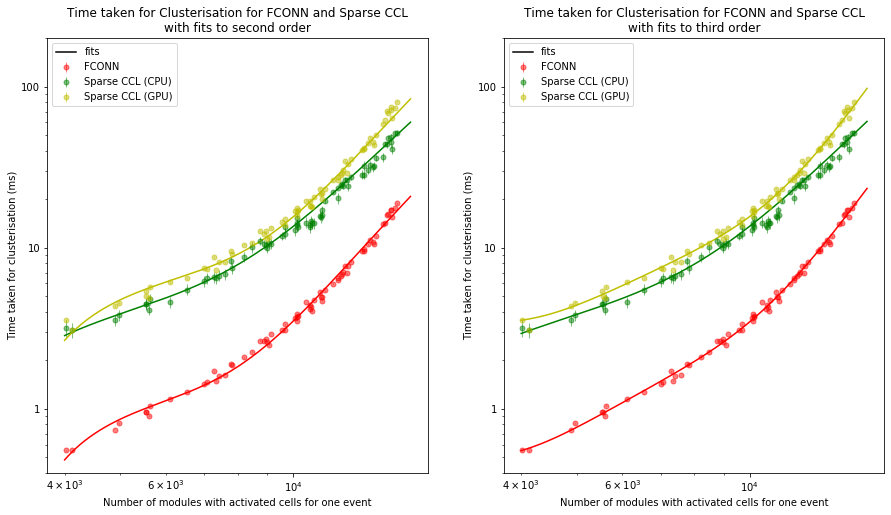

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.errorbar(n_modules_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN", alpha=0.5, color="r")
# ax1.errorbar(n_modules_per_event, hk_fconn_mu_means_1024_threads, yerr=hk_fconn_mu_err_1024_threads,
#             ls="none", marker="o", markersize=5, lw=1, label="FCONN for 1024 threads only", color="b", alpha=0.5)
ax1.errorbar(n_modules_per_event, mu_SPCCL_CPU_means2, yerr=mu_SPCCL_CPU_err2,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (CPU)", color="g", alpha=0.5)
ax1.errorbar(n_modules_per_event, mu_SPCCL_GPU_means, yerr=mu_SPCCL_GPU_err,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU)", color="y", alpha=0.5)

ax1.plot(module_numbers, fconn_fit2, color="r")
# ax1.plot(module_numbers, fconn1024_fit2, color="b", label="FCONN 1024 threads fit")
ax1.plot(module_numbers, spccl_fit2, color="g")
ax1.plot(module_numbers, spccl_gpu_fit2, color="y")
ax1.axhline(100000, color="black", ls="-", label="fits")

ax1.set_ylim(0.0004, 0.2)
ax1.set_xlabel("Number of modules with activated cells for one event")
ax1.set_ylabel("Time taken for clusterisation (ms)")
ax1.set_title("Time taken for Clusterisation for FCONN and Sparse CCL\nwith fits to second order")
ax1.legend()


ax2.errorbar(n_modules_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
            ls="none", marker="o", markersize=5, lw=1, label="FCONN", alpha=0.5, color="r")
# ax2.errorbar(n_modules_per_event, hk_fconn_mu_means_1024_threads, yerr=hk_fconn_mu_err_1024_threads,
#             ls="none", marker="o", markersize=5, lw=1, label="FCONN for 1024 threads only", color="b", alpha=0.5)
ax2.errorbar(n_modules_per_event, mu_SPCCL_CPU_means2, yerr=mu_SPCCL_CPU_err2,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (CPU)", color="g", alpha=0.5)
ax2.errorbar(n_modules_per_event, mu_SPCCL_GPU_means, yerr=mu_SPCCL_GPU_err,
            ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL (GPU)", color="y", alpha=0.5)

ax2.plot(module_numbers, fconn_fit3, color="r")
# ax2.plot(module_numbers, fconn1024_fit3, color="b", label="FCONN 1024 threads fit")
ax2.plot(module_numbers, spccl_fit3, color="g")
ax2.plot(module_numbers, spccl_gpu_fit3, color="y")
ax2.axhline(100000, color="black", ls="-", label="fits")

ax2.set_ylim(0.0004, 0.2)
ax2.set_title("Time taken for Clusterisation for FCONN and Sparse CCL\nwith fits to third order")
ax2.set_xlabel("Number of modules with activated cells for one event")
ax2.set_ylabel("Time taken for clusterisation (ms)")
ax2.legend()

# ax2.errorbar(n_modules_per_event, hk_fconn_mu_means_wrt_event, yerr=hk_fconn_mu_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="FCONN")
# ax2.errorbar(n_modules_per_event, mu_SPCCL_CPU_means_wrt_event, yerr=mu_SPCCL_CPU_err_wrt_event,
#             ls="none", marker="o", markersize=5, lw=1, label="Sparse CCL")
# ax2.legend()
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yticklabels((ax1.get_yticks() * 1000).astype(np.int32))

ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yticklabels((ax2.get_yticks() * 1000).astype(np.int32))

plt.savefig("clusterisation_times_mu_fit.pdf")

plt.show()